# Semantic segmentation of Colon cancer primaries

This is a demonstration of our deep learning pipeline to predict segmentation masks of colon cancer primaries in CT images.

We built our program so that it can easily be run from the command line. In this demonstration we will nevertheless import our functions and create and created an `Args()` class that can be used to specify the settings usually passed by the command line prompt. How to run our program from the command line is shown in the readme.

In [ ]:
import os
import numpy as np
import nibabel
import sys
from glob import glob
import argparse
import json
import random
import matplotlib.pyplot as plt
import PIL

import torch
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
from torchsummary import summary

## Convert NIfTI to Numpy

To train our model and to predict segmentation masks we use axial 2D slices of the CT images, however the original data is provided in 3D NifTI files. We defined the `convert_to_npy()` function to convert 3D NifTI image files to 2D numpy files and save them. In this function we additionally create a JSON file that indexes every single slice. In this index we provide information of whether each slice containes tissue labled as cancer.

In the JSON file we assign each slice to the training or test subsets by calling `create_data_subsets()`. Here, the split ratio and whether to create a split based on individual slices or examples (patients) should be created. For our models we split on individual slices and ensured that the ratio between cancer and non-cancer slices is equal in test and training subset.

Both functions (`convert_to_npy()` and `create_data_subsets()`) are in `dataset.py`.


In [ ]:
def convert_to_npy(args):
    """
        Convert nitfi image files to numpy files

        Args:
            args: arguments from the parser.

    """
    # load a path of image files and sort them
    train_data_path = os.path.join(args.datapath, 'imagesTr')
    label_data_path = os.path.join(args.datapath, 'labelsTr')
    images = sorted(os.listdir(train_data_path))
    labels = sorted(os.listdir(label_data_path))

    # set the location to converted image files
    image_saved_path =args.path +'npy_images/'

    # create a directory of the converted image files
    try:
        os.mkdir(image_saved_path)
    except OSError:
        print ("Creation of the directory %s failed" % image_saved_path)
    else:
        print ("Successfully created the directory %s " % image_saved_path)

    # set the location to converted label files
    label_saved_path = args.path + 'npy_labels/'
    # create a directory of the converted label files
    try:
        os.mkdir(label_saved_path)
    except OSError:
        print ("Creation of the directory %s failed" % label_saved_path)
    else:
        print ("Successfully created the directory %s " % label_saved_path)

    data_index = {}

    for img, label in zip(images,labels):
        # Load 3D CT images
        image_number = str(''.join(filter(str.isdigit, img))).zfill(3)
        training_image = nibabel.load(os.path.join(train_data_path, img))
        training_label = nibabel.load(os.path.join(label_data_path, label))

        for k in range(training_label.shape[2]):
            # axial cuts are made along the z axis (slice)
            image_2d = np.array(training_image.get_fdata()[:, :, k], dtype='int16') # I checked: all values in the nifti files were integers, ranging from -1024 to approx 3000
            label_2d = np.array(training_label.get_fdata()[:, :, k], dtype='uint8') # only contains 1s and 0s
            slice_number = str(k).zfill(3)
            slice_index = image_number+'_'+slice_number

            if len(np.unique(label_2d))!=1:
              contains_cancer = True
            else:
              contains_cancer = False

            data_index[slice_index] = {
                'image': int(image_number),
                'slice': int(slice_number),
                'cancer': contains_cancer,
                'subset': None
            }

            np.save((image_saved_path+'image_{}_{}.npy'.format(image_number,slice_number)), image_2d)
            np.save((label_saved_path +'label_{}_{}.npy'.format(image_number,slice_number)), label_2d)

        print(f'Saved slices of image {image_number}')

    with open(args.path+"data_index.json", "w") as json_file:
        json.dump(data_index,json_file)

def create_data_subsets(args):
    """
        Split the data for test and train.
        You can choose how to split the data by examples(patients) or by slices.
        It is saved as json file and the json file is used one of arguments of ConlonDataset on dataset.py

        Args:
            args: arguments from the parser.

    """
    data_index_file = args.path+"data_index.json"

    with open(data_index_file) as json_file:
        data_index = json.load(json_file)

        if args.split_on == "examples":
          image_index = [v['image'] for _, v in data_index.items()]
          unique_images = set(image_index)
          test_length = int(len(unique_images)*args.split)
          test_images = random.sample(unique_images,test_length)
          test_slices = [k for k,v in data_index.items() if v['image'] in test_images]
          for k,_ in data_index.items():
            if k in test_slices:
              data_index[k]['subset'] = 'test'
            else:
              data_index[k]['subset'] = 'train'

        if args.split_on == "slices":

            cancer_slice_index = [k for k,v  in data_index.items() if v['cancer'] is True]
            non_cancer_slice_index = [k for k, v in data_index.items() if v['cancer'] is False]
            cancer_slice_length = len(cancer_slice_index)
            non_cancer_slice_length = len(non_cancer_slice_index)
            slice_length = cancer_slice_length + non_cancer_slice_length

            proportion_cancer = cancer_slice_length/(non_cancer_slice_length+cancer_slice_length)
            test_length = int(slice_length*args.split)
            test_cancer_slices_length = int(test_length*proportion_cancer)
            test_non_cancer_slices_length = test_length-test_cancer_slices_length

            test_slices = [*random.sample(cancer_slice_index, test_cancer_slices_length),
                           *random.sample(non_cancer_slice_index,test_non_cancer_slices_length)]

            for k,_ in data_index.items():
                if k in test_slices:
                    data_index[k]['subset'] = 'test'
                else:
                    data_index[k]['subset'] = 'train'

    with open(args.path+"data_index_subsets.json", "w") as json_file:
        json.dump(data_index, json_file)

In [ ]:
class Args():
    data_path = './Task10_Colon'
    path = './data/'
    split_on = "slices"
    split = 0.1

args = Args()

In [ ]:
convert_to_npy(args)
create_data_subsets(args)

# 2. Dataset and Data Loader

**1) Dataset**

We creates a Custom Dataset; ColonDataset. It uses JSON file which created from *create_data_subsets()* function. *ColonDataset()* class is at **data_loading.py**.  

We can set a sampling method. Otherwise, it uses the original dataset. Three sampling methods are undersample, oversample and only_tumor. Each sampling methods are defined as *get_undersample_files()*, *get_oversample_files()*, *get_only_tumor_files*, and *get_original_dataset()* at **data_loading.py**. 

When the data set is for train, it transforms the data set by resize, random crop, horizontal flipping, vertical flipping, and normalization. Otherwise, it transforms the data set by resize and normalization.

After creating ColonDataset; we split the dataset into train and valid set. This logic is implemented in the *load_datasets()* function. The load_datasets() function is at *train.py*.

**2) Data Loader**

We use *DataLoader* from **pytorch**(torch.utils.data.DataLoader). At *load_dataloader()* function, we creates two data loaders of train and valid set and put both of them in the dictionary as 'train' and 'val'. This dictionary is going to use in the training loop later.

In [ ]:
# undersample
def get_undersample_files(json_dir):
  with open(json_dir) as json_file:
    data_index = json.load(json_file)

  index_with_cancer = [k for k,v in data_index.items() if (v['cancer'] == True) & (v['subset']=='train')]
  index_no_cancer = [k for k,v in data_index.items() if (v['cancer'] == False) & (v['subset']=='train')]

  # randomly draw indices from set of indices of slices without cancer
  # same number of slices with and without cancer tissue
  rand_index_no_cancer = random.choices(index_no_cancer,k=len(index_with_cancer))

  image_files, label_files = [], []

  # add file names of images and labels to list
  for slice_index in rand_index_no_cancer:
    image = 'image_'+slice_index + '.npy'
    label = 'label_'+slice_index + '.npy'
    image_files.append(image)
    label_files.append(label)

  for slice_index in index_with_cancer:
    image = 'image_'+slice_index + '.npy'
    label = 'label_'+slice_index+ '.npy'
    image_files.append(image)
    label_files.append(label)
  
  return(image_files,label_files)

# oversample
def get_oversample_files(json_dir):

  with open(json_dir) as json_file:
    data_index = json.load(json_file)

  index_with_cancer = [k for k,v in data_index.items() if (v['cancer'] == True) & (v['subset']=='train')]
  index_no_cancer = [k for k,v in data_index.items() if (v['cancer'] == False) & (v['subset']=='train')]

  # randomly draw indices from set of indices of slices without cancer
  # same number of slices with and without cancer tissue
  rand_index_with_cancer = random.choices(index_with_cancer,k=len(index_no_cancer))

  image_files, label_files = [], []

  # add file names of images and labels to list

  for slice_index in rand_index_with_cancer:
    image = 'image_'+slice_index + '.npy'
    label = 'label_'+slice_index + '.npy'
    image_files.append(image)
    label_files.append(label)

  for slice_index in index_no_cancer:
    image = 'image_'+slice_index + '.npy'
    label = 'label_'+slice_index+ '.npy'
    image_files.append(image)
    label_files.append(label)
  
  return(image_files,label_files)

# get_only_tumor_files() returns a list of all files that contain cancer tissue.
# no files without cancer tissue will be returned
def get_only_tumor_files(json_dir):
  with open(json_dir) as json_file:
    data_index = json.load(json_file)

  index_with_cancer = [k for k,v in data_index.items() if (v['cancer'] == True) & (v['subset']=='train')]

  image_files, label_files = [], []

  # add file names of images and labels to list
  for slice_index in index_with_cancer:
    image = 'image_'+slice_index + '.npy'
    label = 'label_'+slice_index+ '.npy'
    image_files.append(image)
    label_files.append(label)
  
  return(image_files,label_files)

# get_original_dataset() returns a dataset without any sampling method
def get_original_dataset(json_dir, test):
    with open(json_dir) as json_file:
        data_index = json.load(json_file)

    if test is True:
        file_index = [k for k, v in data_index.items() if v['subset'] == 'test']
    else:
        file_index = [k for k,v in data_index.items() if v['subset'] == 'train']

    image_files, label_files = [], []

    # add file names of images and labels to list
    for slice_index in file_index:
        image = 'image_' + slice_index + '.npy'
        label = 'label_' + slice_index + '.npy'
        image_files.append(image)
        label_files.append(label)

    return(image_files, label_files)

# dataset class for primary colon cancer dataset
class ColonDataset(Dataset):
    """Colon Cancer dataset."""
    def __init__(self, image_dir, label_dir, json_dir, image_size, torch_transform, balance_dataset=None, test=None):
        """
        Args:
            image_dir: Path to image folder.
            label_dir: Path to label folder.
            csv_dir: Path to csv file, which gives information whether slice contains annotated cancer pixels.
            balance_dataset (optional): options to create a dataset with balanced numbers of slices
                containing cancer tissue or not containing cancer
                'oversample': uniformly draws samples from minority class to reach equal size
                'undersample': uniformly draws samples from majority class to reach equal size
                'only_tumor': only includes slices with cancer tissue
                None: no balance method is applied
        """
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.json_dir = json_dir
        self.image_size = image_size
        self.test = test
        self.balance_dataset = balance_dataset
        self.torch_transform = torch_transform
        if self.test is None:
            if self.balance_dataset == "undersample":
                self.image_files, self.label_files = get_undersample_files(self.json_dir)
            if self.balance_dataset == "oversample":
                self.image_files, self.label_files = get_oversample_files(self.json_dir)
            if self.balance_dataset == 'only_tumor':
                self.image_files, self.label_files = get_only_tumor_files(self.json_dir)
        if (self.balance_dataset is None) or (self.test is True):
            self.image_files, self.label_files = get_original_dataset(self.json_dir, self.test)

    def __len__(self):
      return len(self.image_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_path = os.path.join(self.image_dir,
                                  self.image_files[idx])
        label_path = os.path.join(self.label_dir,
                                  self.label_files[idx])
        
        image = np.load(image_path)
        label = np.load(label_path)
        if self.torch_transform:
            x, y = self.transform(image, label)

        return [x, y]

    def transform(self, image, label):
      # to PIL
      image = PIL.Image.fromarray(image)
      label = PIL.Image.fromarray(label)

      # Resize
      if self.test == None:
        image = TF.resize(image, size=(self.image_size+44, self.image_size+44))
        label = TF.resize(label, size=(self.image_size+44, self.image_size+44))
      else:
        image = TF.resize(image, size=(self.image_size, self.image_size))
        label = TF.resize(label, size=(self.image_size, self.image_size))

      # Random crop
      if self.test == None:
        i, j, h, w = transforms.RandomCrop.get_params(
            image, output_size=(self.image_size, self.image_size))
        image = TF.crop(image, i, j, h, w)
        label = TF.crop(label, i, j, h, w)

      # Random horizontal flipping
      if self.test == None:
        if random.random() > 0.5:
            image = TF.hflip(image)
            label = TF.hflip(label)

      # Random vertical flipping
      if self.test == None:
        if random.random() > 0.5:
            image = TF.vflip(image)
            label = TF.vflip(label)

      # Transform to tensor
      image = torch.from_numpy(np.array(image)) # to_tensor: /opt/conda/conda-bld/pytorch_1587428094786/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. 
      image = image.unsqueeze(0).type(torch.FloatTensor)
      label = torch.from_numpy(np.array(np.expand_dims(label, 0))).type(torch.FloatTensor)
      # Normalize
      image = TF.normalize(image, mean=(-531.28,), std=(499.68,))


      return image, label

In [ ]:
def load_datasets(args):
    """load the dataset (ColonDataset) and split the dataset into train and validation set   

    Args:
        args: arguments from the parser.
        
    Return:
        train_dataset: a dataset for training
        val_dataset: a dataset for validation
    """
    dataset = ColonDataset(
        image_dir=args.trainimages,
        label_dir=args.trainlabels,
        json_dir=args.jsonfile,
        image_size=args.image_size,
        torch_transform=args.transform,
        balance_dataset=args.dataset_type
    )
    # determine train and validation set size and split randomly
    train_size = int(args.split_ratio*len(dataset))
    val_size = len(dataset)-train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    return train_dataset, val_dataset

def load_dataloader(args, train, valid):
    """load a dataloader using train dataset and validation dataset (ColonDataset)

    Args:
        args: the object which store arguments from the parser
        train: train dataset (ColonDataset)
        valid: validation dataset (ColonDataset)
        
    Return:
        dataloader: a dataloader for training 
    """
    dataloader = {
       'train': DataLoader(train, shuffle=True, batch_size=args.train_batch, num_workers=4),
        'val': DataLoader(valid, shuffle=True, batch_size=args.valid_batch, num_workers=4)
    }
    return dataloader

In [ ]:
class Args():
    split_ratio = 0.9
    train_batch = 12
    valid_batch = 12
    trainimages = "./data/npy_images"
    trainlabels = "./data/npy_labels"
    jsonfile = "./data/data_index_subsets.json"
    transform = True
    dataset_type = "only_tumor"
    image_size = 256

args = Args()

In [ ]:
train, valid = load_datasets(args)
train_dataloader = load_dataloader(args, train, valid)

# 3. Visualize images from the data loader
CT images from the first batch of train_dataloader.

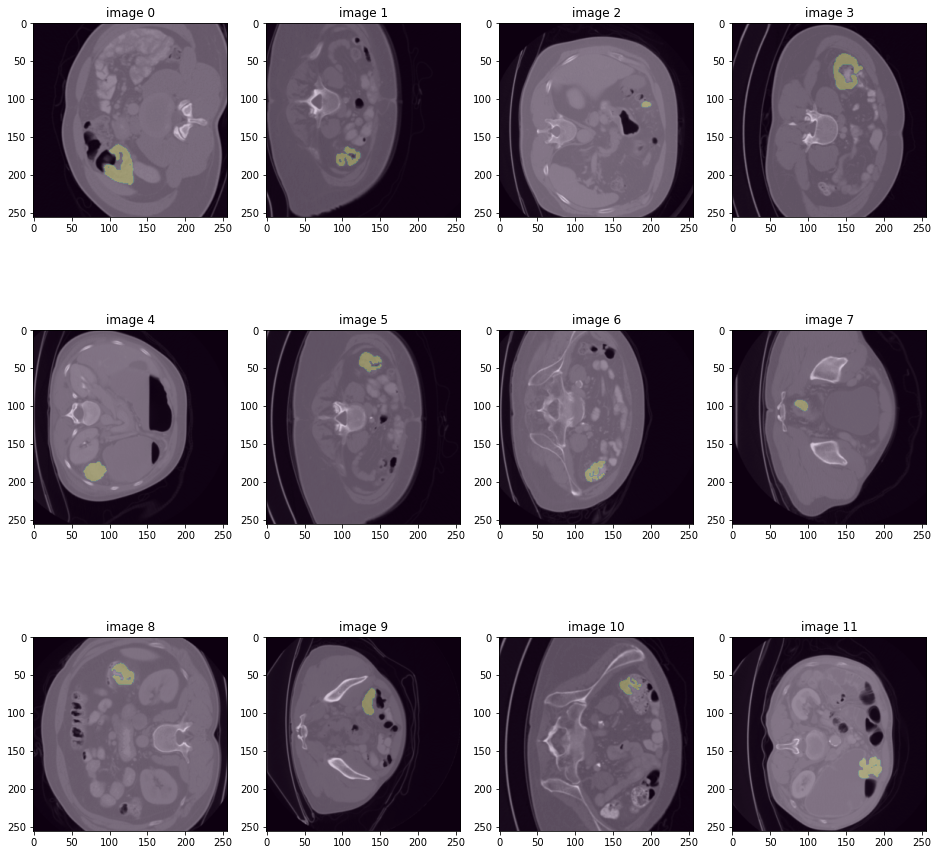

In [ ]:
imgs, labels = next(iter(train_dataloader['train']))

columns = 4
rows = 3
fig=plt.figure(figsize=(16, 16))
for i, (img, label) in enumerate(zip(imgs, labels)):
    fig.add_subplot(rows, columns, i+1)
    plt.title('image ' + str(i))
    plt.imshow(img[0], cmap='gray')
    plt.imshow(label[0],alpha=0.2)
plt.show()

# 4. U-Net Model
We use the U-Net model and the combination of ResNet with the U-Net for image segmentation task. In this demo, we use the U-Net model. Two models are implemented at **architecture.py**.

In [ ]:
# convolution blocks for contracting path of unet
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

# convolution blocks for expansive path of unet
def double_conv_up(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
    )

# Unet architecture
class UNet(nn.Module):
    """
    A unet architecture implementation
    http://lmb.informatik.uni-freiburg.de/Publications/2015/RFB15a
    """
    def __init__(self, n_channel, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(n_channel, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        
        self.dconv_down5 = double_conv(512, 1024)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up4 = double_conv_up(512 + 1024, 512)
        self.dconv_up3 = double_conv_up(256 + 512, 256)
        self.dconv_up2 = double_conv_up(128 + 256, 128)
        self.dconv_up1 = double_conv_up(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
                
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4)
        x = self.dconv_down5(x)

        x = self.upsample(x)    
        x = torch.cat([x, conv4], dim=1)
        x = self.dconv_up4(x)
        x = self.upsample(x)  
   
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)
        x = self.upsample(x) 
    
        x = torch.cat([x, conv2], dim=1)      
        x = self.dconv_up2(x)
        x = self.upsample(x)    
        x = torch.cat([x, conv1], dim=1)   
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

In [ ]:
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0") # set device to GPU if available
model = UNet(n_channel=1, n_class=1).to(device)
summary(model, input_size=(1, args.image_size, args.image_size))

RuntimeError: CUDA error: out of memory

# 5. Loss function
We use the combination of cross entrophy loss and dice loss to optimize the model. 

The cross entrophy loss is from *pytorch library*. We implements The dice coefficient at **loss.py**. The dice loss is *(1 - dice coefficient)*.

In [ ]:
def dice_coef(pred, target, smooth = 1.):
    """
        Calculate the dice coefficient

        Args:
            pred: predictions from the model 
            target: ground truths
            smooth: to prevent division by zero. 
                    Also, having a larger smooth value (also known as Laplace smooth, or Additive smooth) can be used to avoid overfitting. 
                    The larger the smooth value the closer the following term is to 1 (if everything else is fixed).

        Return:
            dice.mean(): the average value of dice coefficients  
    """
    pred = pred.contiguous()
    target = target.contiguous()    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    dice = ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth))
    return dice.mean()


def calc_loss(pred, target, metrics, bce_weight=1.0, dc_weight=1.0):
    """
        Calculate the loss

        Args:
            pred: predictions from the model 
            target: ground truths
            metrics: a dictionary to save losses
            bce_weight: a weight for binary cross entropy
            dc_weight: a weight for dice loss 

        Return:
            loss: the combination of dice loss and binary cross entropy
    """
    bce = F.binary_cross_entropy_with_logits(pred, target)
    pred = torch.sigmoid(pred)
    dice_loss = 1 - dice_coef(pred, target)
    loss = bce * bce_weight + dice_loss * dc_weight

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice_loss'] += dice_loss.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss


def print_metrics(metrics, epoch_samples, phase):
    """
        Print out metrics

        Args:
            metrics: a dictionary which has calculated losses
            epoch_samples: the total number of samples for one epoch 
            phase: a phase of the training

        Return:
            loss: the combination of dice loss and binary cross entropy
    """
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
    print("{}: {}".format(phase, ", ".join(outputs)))

# 6. Train

We use *SGD (Stochastic gradient descent)* optimizer. The scheduler is *ReduceLROnPlateau*. It allows dynamic learning rate reducing based on some validation measurements. Both of them are from **pytorch** library. 

Early Stopping technique is also implemented at **train.py**. Early stopping is a method that allows you to specify an arbitrarily large number of training epochs and stop training once the model performance stops improving on the validation dataset.

We define *train_method()* function at **train.py**. This function receives optimizer, scheduler, and other parameters and starts training. It saves the best model which shows the lowest validation loss. In the original code, we use Tensorbaord to visualize metrics after finishing training. We also save metrics as a JSON file to make us compare the results of each model easily. However, we comments out them in this demo.



In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_val_loss = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model, optimizer):
        if self.best_val_loss is None:
            self.best_val_loss = val_loss
            self.save_checkpoint(val_loss, model, optimizer)
        elif val_loss > self.best_val_loss:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_val_loss = val_loss
            self.save_checkpoint(val_loss, model, optimizer)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, optimizer):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving best model ...')
        torch.save({'model_state_dict':model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict()}, 
                    f"{args.model_path}best_metric_{args.model}_{args.dataset_type}_{args.epochs}.pth")
        self.val_loss_min = val_loss

# adapted from https://github.com/mateuszbuda/brain-segmentation-pytorch
def train_model(model, optimizer, scheduler, device, num_epochs, dataloaders, info=None, fine_tune=False):
    """
        Train the model

        Args:
            model: A neural netowrk model for training
            optimizer: A optimizer to calculate gradients
            scheduler: A scheduler to change a learning rate
            device: gpu or cpu
            num_epochs: a number of epochs
            dataloaders: a data loader
            info: a dictionary to save metrics
            fine_tune: If True, it saved metrics of the fine tuning phase

        Return:
            model: A trained model
            metric_train: Metrics from training phase
            metric_valid: Metrics from validation phase
    """
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    # Initialize list to save loss from train and validation phase
    epoch_train_loss = list()
    epoch_valid_loss = list()
    epoch_train_dice_loss = list()
    epoch_valid_dice_loss = list()
    epoch_train_bce = list()
    epoch_valid_bce = list()
    
    # Initialize SummaryWriter to visualize losses on Tensorboard
    # writer = SummaryWriter()

    # Initialize EarlyStopping
    early_stopping = EarlyStopping(patience=args.earlystop, verbose=True)
    
    # Training starts
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        since = time.time()
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # initialize metric dict to save losses for each epoch
            metrics = defaultdict(float)
            epoch_samples = 0

            # Load a batch of images and labels 
            for images, labels in dataloaders[phase]:
                images = images.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images)
                    loss = calc_loss(outputs, labels, metrics)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                epoch_samples += images.size(0)

            # print metrics 
            print_metrics(metrics, epoch_samples, phase)

            # save the loss of the current epoch
            epoch_loss = metrics['loss'] / epoch_samples

            if phase == 'train':
                # save training metrics for tensorboard
                # writer.add_scalar('Loss(BCE+Dice)/train', epoch_loss, epoch)
                # writer.add_scalar('Dice Loss/train', metrics['dice_loss']/ epoch_samples, epoch)
                # writer.add_scalar('BCE/train', metrics['bce']/ epoch_samples, epoch)

                # save training metrics for later use ;)
                epoch_train_loss.append(metrics['loss']/ epoch_samples)
                epoch_train_bce.append(metrics['bce']/ epoch_samples)
                epoch_train_dice_loss.append(metrics['dice_loss']/ epoch_samples)

            elif phase == 'val':
                # save validation metrics for tensorboard
                # writer.add_scalar('learning_rate', optimizer.param_groups[0]['lr'], epoch) # to plot LR reduction
                # writer.add_scalar('Loss(BCE+Dice)/valid', metrics['loss'] / epoch_samples, epoch)
                # writer.add_scalar('Dice Loss/valid', metrics['dice_loss'] / epoch_samples, epoch)
                # writer.add_scalar('BCE/valid', metrics['bce'] / epoch_samples, epoch)

                # save validation metrics for later use
                epoch_valid_loss.append(metrics['loss']/ epoch_samples)
                epoch_valid_bce.append(metrics['bce']/ epoch_samples)
                epoch_valid_dice_loss.append(metrics['dice_loss']/ epoch_samples)

                scheduler.step(epoch_loss) # pass loss to ReduceLROnPlateau scheduler

                early_stopping(epoch_loss, model, optimizer) #  evaluate early stopping criterion

                # compare loss and deep copy the model
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since # compute time of epoch
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

        # check early stop is True or not
        if early_stopping.early_stop:
            print(f"Early stopping after epoch {epoch}")
            # if fine_tune == False:
            #     info['early stop'] = 'True'
            #     info['stopping LR'] = optimizer.param_groups[0]['lr']
            #     info['stopping epoch'] = epoch+1
            #     info['best loss'] = best_loss
            # else:
            #     info['fine_tune_early stop'] = 'True'
            #     info['fine_tune_stopping LR'] = optimizer.param_groups[0]['lr']
            #     info['fine_tune_stopping epoch'] = epoch+1
            #     info['fine_tune_best loss'] = best_loss
            break   

    # check early stop is True or not
    # if early_stopping.early_stop != True:
    #     if fine_tune == False:
    #         info['early stop'] = 'False'
    #         info['stopping LR'] = optimizer.param_groups[0]['lr']
    #         info['stopping epoch'] = num_epochs
    #         info['best loss'] = best_loss
    #     else:
    #         info['fine_tune_early stop'] = 'False'
    #         info['fine_tune_stopping LR'] = optimizer.param_groups[0]['lr']
    #         info['fine_tune_stopping epoch'] = num_epochs
    #         info['fine_tune_best loss'] = best_loss
    
    print('Best val loss: {:4f}'.format(best_loss))

    # collect all metrics
    metric_train = (epoch_train_loss, epoch_train_bce, epoch_train_dice_loss)
    metric_valid = (epoch_valid_loss, epoch_valid_bce, epoch_valid_dice_loss)

    # load best model weights (necessary for fine tuning of ResNet-UNet)
    model.load_state_dict(best_model_wts)

    #writer.close() # end tensorboard writing

    return model, metric_train, metric_valid

In [ ]:
class Args():
    model_path = "./save/models/"
    model = "unet"
    dataset_type = "only_tumor"
    lr = 0.001
    epochs = 200
    earlystop = 30
    sched_patience = 10
    
args = Args()

In [ ]:
# set device
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0") # set device to GPU if available
# specify optimizer function
optimizer = SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=args.lr, momentum=0.9)
# initialise learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', threshold_mode='abs', min_lr=1e-8, factor=0.1, patience=args.sched_patience)
# intialize the model
model = UNet(n_channel=1, n_class=1).to(device)
# start train
model, metric_t, metric_v = train_model(model, optimizer, scheduler, device, args.epochs, colon_dataloader, info_train)


# 7. Test
We define *load_datasets()* and *load_dataloader()* functions at **test.py** to load the test set which is splitted at the *step 1: Convert NIfTI to Numpy*. 

Similar to train_model() at the *step 7: Train*, we also define *test_model()* at **test.py** which starts evaluating the model and prints the evaluation metrics at the end. 

In this demo, we are going to load the best model which is already trained using oversample sampling method with U-Net model.

In [ ]:
def load_datasets(args):
    """load the dataset for evaluation   

    Args:
        args: arguments from the parser.
        
    """
    dataset = ColonDataset(
        image_dir=args.testimages,
        label_dir=args.testlabels,
        json_dir=args.jsonfile,
        image_size=args.image_size,
        torch_transform=args.transform,
        test=True
    )
    return dataset

def load_dataloader(dataset):
    """load a dataloader using a dataset (ColonDataset)

    Args:
        dataset: a dataset to create a data loader

    Return:
        dataloader: a dataloader for evaluation 
    """
    dataloader = {
       'test': DataLoader(dataset, shuffle=False, batch_size=1)
    }
    return dataloader

def test_model(model, device, dataloaders, plot_path=None, info=None):
    """
        Evaluate the model

        Args:
            model: A neural netowrk model for evaluation
            device: gpu or cpu
            dataloaders: a data loader
            plot_path: a path to save plotting image files
            info: a dictionary to save metrics of evaluation
        
        Return:
            test_dice: the average dice score of the evaluation
        """
    # load the trained model
    check = torch.load(f"{args.model_path}best_metric_{args.model}_{args.metric_dataset_type}_{args.epochs}.pth")
    model.load_state_dict(check['model_state_dict']) 
    
    # initialize to save dice scores
    test_dice = list()
    test_cancer_dice = list()
    test_non_cancer_dice = list()
    
    print('-' * 10)
    print('The Evaluation Starts ...')
    print('-' * 10)
    since = time.time()
    # Test Phase
    model.eval()   # Set model to evaluate mode
    
    # initilize dictionary to save metrics for evaluation
    test_metrics = {}
    
    # initilize variables to save metrics for evaluation
    test_samples = 0
    test_cancer_samples = 0
    test_non_cancer_samples = 0
    gt_c_pd_c_overlap = 0
    gt_c_pd_c_no_overlap = 0
    gt_c_pd_no_c = 0
    gt_n_pd_c = 0
    gt_n_pd_n = 0

    # to count images
    i = 0

    # load image and label
    for images, labels in dataloaders['test']:
        cancer = 'non-cancer'
        pd = 'non-cancer'
        images = images.to(device)
        labels = labels.to(device)
        with torch.set_grad_enabled(False):
            outputs = model(images)
            preds = torch.sigmoid(outputs)
            preds = torch.round(preds)
            dice_score = dice_coef(preds, labels)
            predicted_num_class = len(torch.unique(preds))
            number_label_class = len(torch.unique(labels)) 
        #if len(torch.unique(labels)) != 1:
        #    plot_result(inputs, labels, preds, i, plot_path, dice_score)
        #if i % 50 == 0:
        #    plot_result(inputs, labels, preds, i, plot_path, dice_score)
        
        # check the image has cancer
        if number_label_class != 1:
            cancer = 'cancer'
            test_cancer_dice.append(dice_score)
            test_cancer_samples += 1
            # check the prediction has cancer and save some metrics
            if predicted_num_class != 1 and dice_score >= 0.009:
                gt_c_pd_c_overlap += 1
                pd = 'cancer'
                #plot_result(inputs, labels, preds, i, plot_path, dice_score)
            elif predicted_num_class == 1:
                gt_c_pd_no_c += 1
                #plot_result(inputs, labels, preds, i, plot_path, dice_score)
            else:
                gt_c_pd_c_no_overlap += 1
                pd = 'cancer'
                #plot_result(inputs, labels, preds, i, plot_path, dice_score)
        else:
            test_non_cancer_dice.append(dice_score)
            test_non_cancer_samples += 1
            if predicted_num_class == 1:
                gt_n_pd_n += 1
            if predicted_num_class == 2:
                gt_n_pd_c += 1
        #print(f"The {i} image's dice score is {dice_score}.")
        test_dice.append(dice_score)
        # save dice score, ground truth, and prediction for each slice 
        # info['dice_score_each_slice'].append({i: dice_score.item(), "gt": cancer, 'pd': pd})
        test_samples += 1
        i += 1

    # calculate average dice score for the test set
    average_dice_score = sum(test_dice) / test_samples
    average_cancer_dice_score = sum(test_cancer_dice) / test_cancer_samples    
    average_non_cancer_dice_score = sum(test_non_cancer_dice) / test_non_cancer_samples

    # save metrics to the info
    # info['number of cancer case'] = test_cancer_samples
    # info['number of non-cancer case'] = test_non_cancer_samples

    # info['average_dice_score'] = average_dice_score.item()
    # info['average_cancer_dice_score'] = average_cancer_dice_score.item()
    # info['average_non_cancer_dice_score'] = average_non_cancer_dice_score.item()

    # info['gt_c_pd_c_overlap'] = gt_c_pd_c_overlap
    # info['gt_c_pd_c_no_overlap'] = gt_c_pd_c_no_overlap
    # info['gt_c_pd_no_c'] = gt_c_pd_no_c

    # info['gt_n_pd_n'] = gt_n_pd_n
    # info['gt_n_pd_c'] = gt_n_pd_c

    # print all the results of evaluation
    print(f"The total samples: {test_samples}")
    print(f"The average dice score is {average_dice_score}.")
    print(f"The number of cancer samples: {test_cancer_samples}")
    print(f"The average dice score of the slices which have cancer is {average_cancer_dice_score}.")
    print(f"The number of correct cases when the prediction predicts some poriton of the cancer: {gt_c_pd_c_overlap}")
    print(f"The number of incorrect cases when the prediction predicts some poriton of the cancer: {gt_c_pd_c_no_overlap}")
    print(f"The number of cases when the prediction predicts no cancer but it has cancer: {gt_c_pd_no_c}")
    print(f"The number of non-cancer samples: {test_non_cancer_samples}")
    print(f"The average dice score of the slices which have non-cancer is {average_non_cancer_dice_score}.")
    print(f"The number of cases when the prediction predicts no cancer when it has no cancer: {gt_n_pd_n}")
    print(f"The number of cases when the prediction predicts cancer when it has no cancer: {gt_n_pd_c}")
    
    time_elapsed = time.time() - since
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

In [ ]:
class Args():
    testimages = "./data/npy_images"
    testlabels = "./data/npy_labels"
    jsonfile = "./data/data_index_subsets.json"
    image_size = 256
    transform = True
    model_path = "./save/models/"
    model = "unet"
    datset_type = "oversample"
    epochs = 200
    plot_path = "./eval_plot/"
    
args = Args()

In [ ]:
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0") # set device to GPU if available
model = UNet(n_channel=1, n_class=1).to(device)
test = load_datasets(args)
test_dataloader = load_dataloader(test)
test_model(model, device, colon_dataloader)

# 8. Visualize predictions from the trained model
